[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 0, Loss: 0.6969, Train Accuracy: 0.4338, Val Accuracy: 0.4333
Epoch 10, Loss: 0.5668, Train Accuracy: 0.4338, Val Accuracy: 0.4333
Epoch 20, Loss: 0.5489, Train Accuracy: 0.4338, Val Accuracy: 0.4333
Epoch 30, Loss: 0.5475, Train Accuracy: 0.4338, Val Accuracy: 0.4333
Epoch 40, Loss: 0.5473, Train Accuracy: 0.4338, Val Accuracy: 0.4333
Epoch 50, Loss: 0.5472, Train Accuracy: 0.4338, Val Accuracy: 0.4333
Epoch 60, Loss: 0.5471, Train Accuracy: 0.4338, Val Accuracy: 0.4333
Epoch 70, Loss: 0.5470, Train Accuracy: 0.4338, Val Accuracy: 0.4333
Epoch 80, Loss: 0.5453, Train Accuracy: 0.4338, Val Accuracy: 0.4333
Epoch 90, Loss: 0.5345, Train Accuracy: 0.4368, Val Accuracy: 0.4333
Epoch 100, Loss: 0.5006, Train Accuracy: 0.6262, Val Accuracy: 0.6531
Epoch 110, Loss: 0.4523, Train Accuracy: 0.8006, Val Accuracy: 0.7695
Epoch 120, Loss: 0.4209, Train Accuracy: 0.8410, Val Accuracy: 0.8235
Epoch 130, Loss: 0.4045, Train Accuracy: 0.8698, Val Accuracy: 0.8606
Epoch 140, Loss: 0.3917, Train 

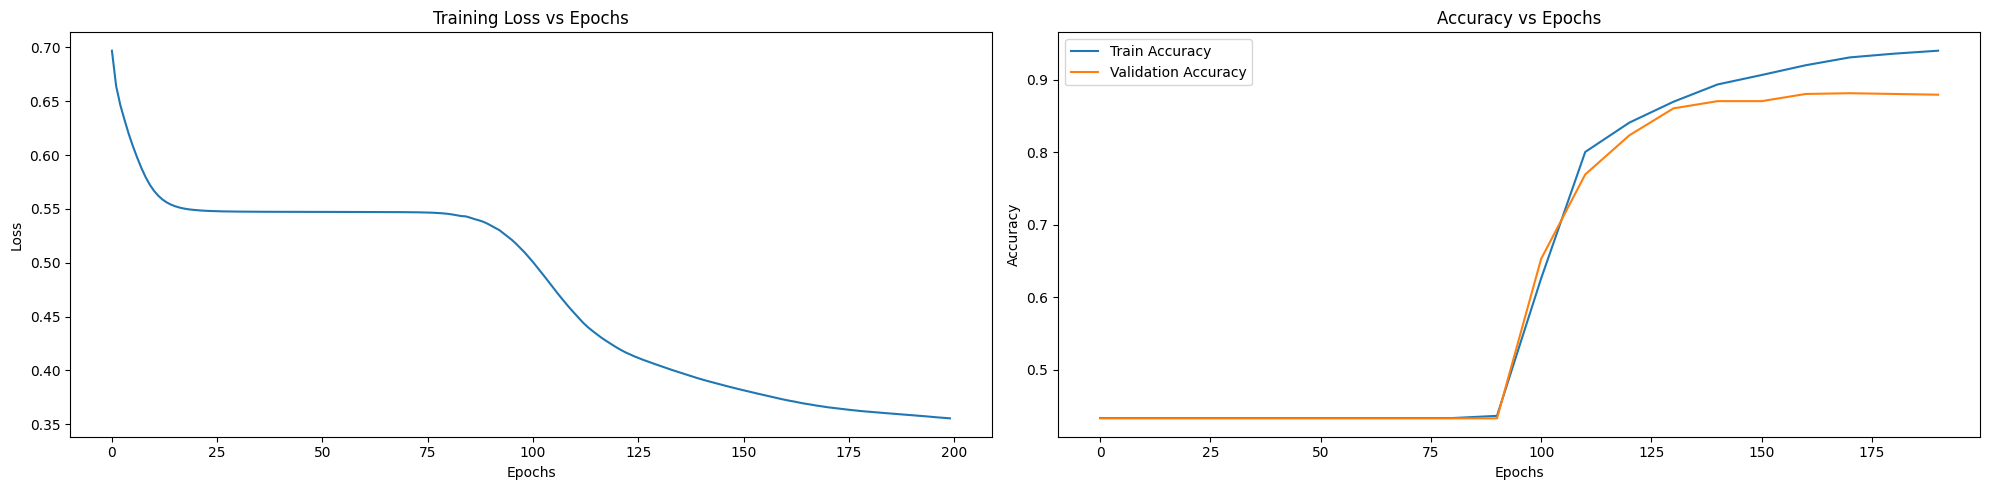

,Precision,Recall,F1-Score,Accuracy,ROC-AUC
Train,0.953485,0.933139,0.942788,0.959893,0.954096
Test,0.891534,0.855769,0.871698,0.911765,0.939725



Classification Report (Train):
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       350
           1       0.96      0.98      0.97      1146

    accuracy                           0.96      1496
   macro avg       0.95      0.93      0.94      1496
weighted avg       0.96      0.96      0.96      1496


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        88
           1       0.93      0.96      0.94       286

    accuracy                           0.91       374
   macro avg       0.89      0.86      0.87       374
weighted avg       0.91      0.91      0.91       374



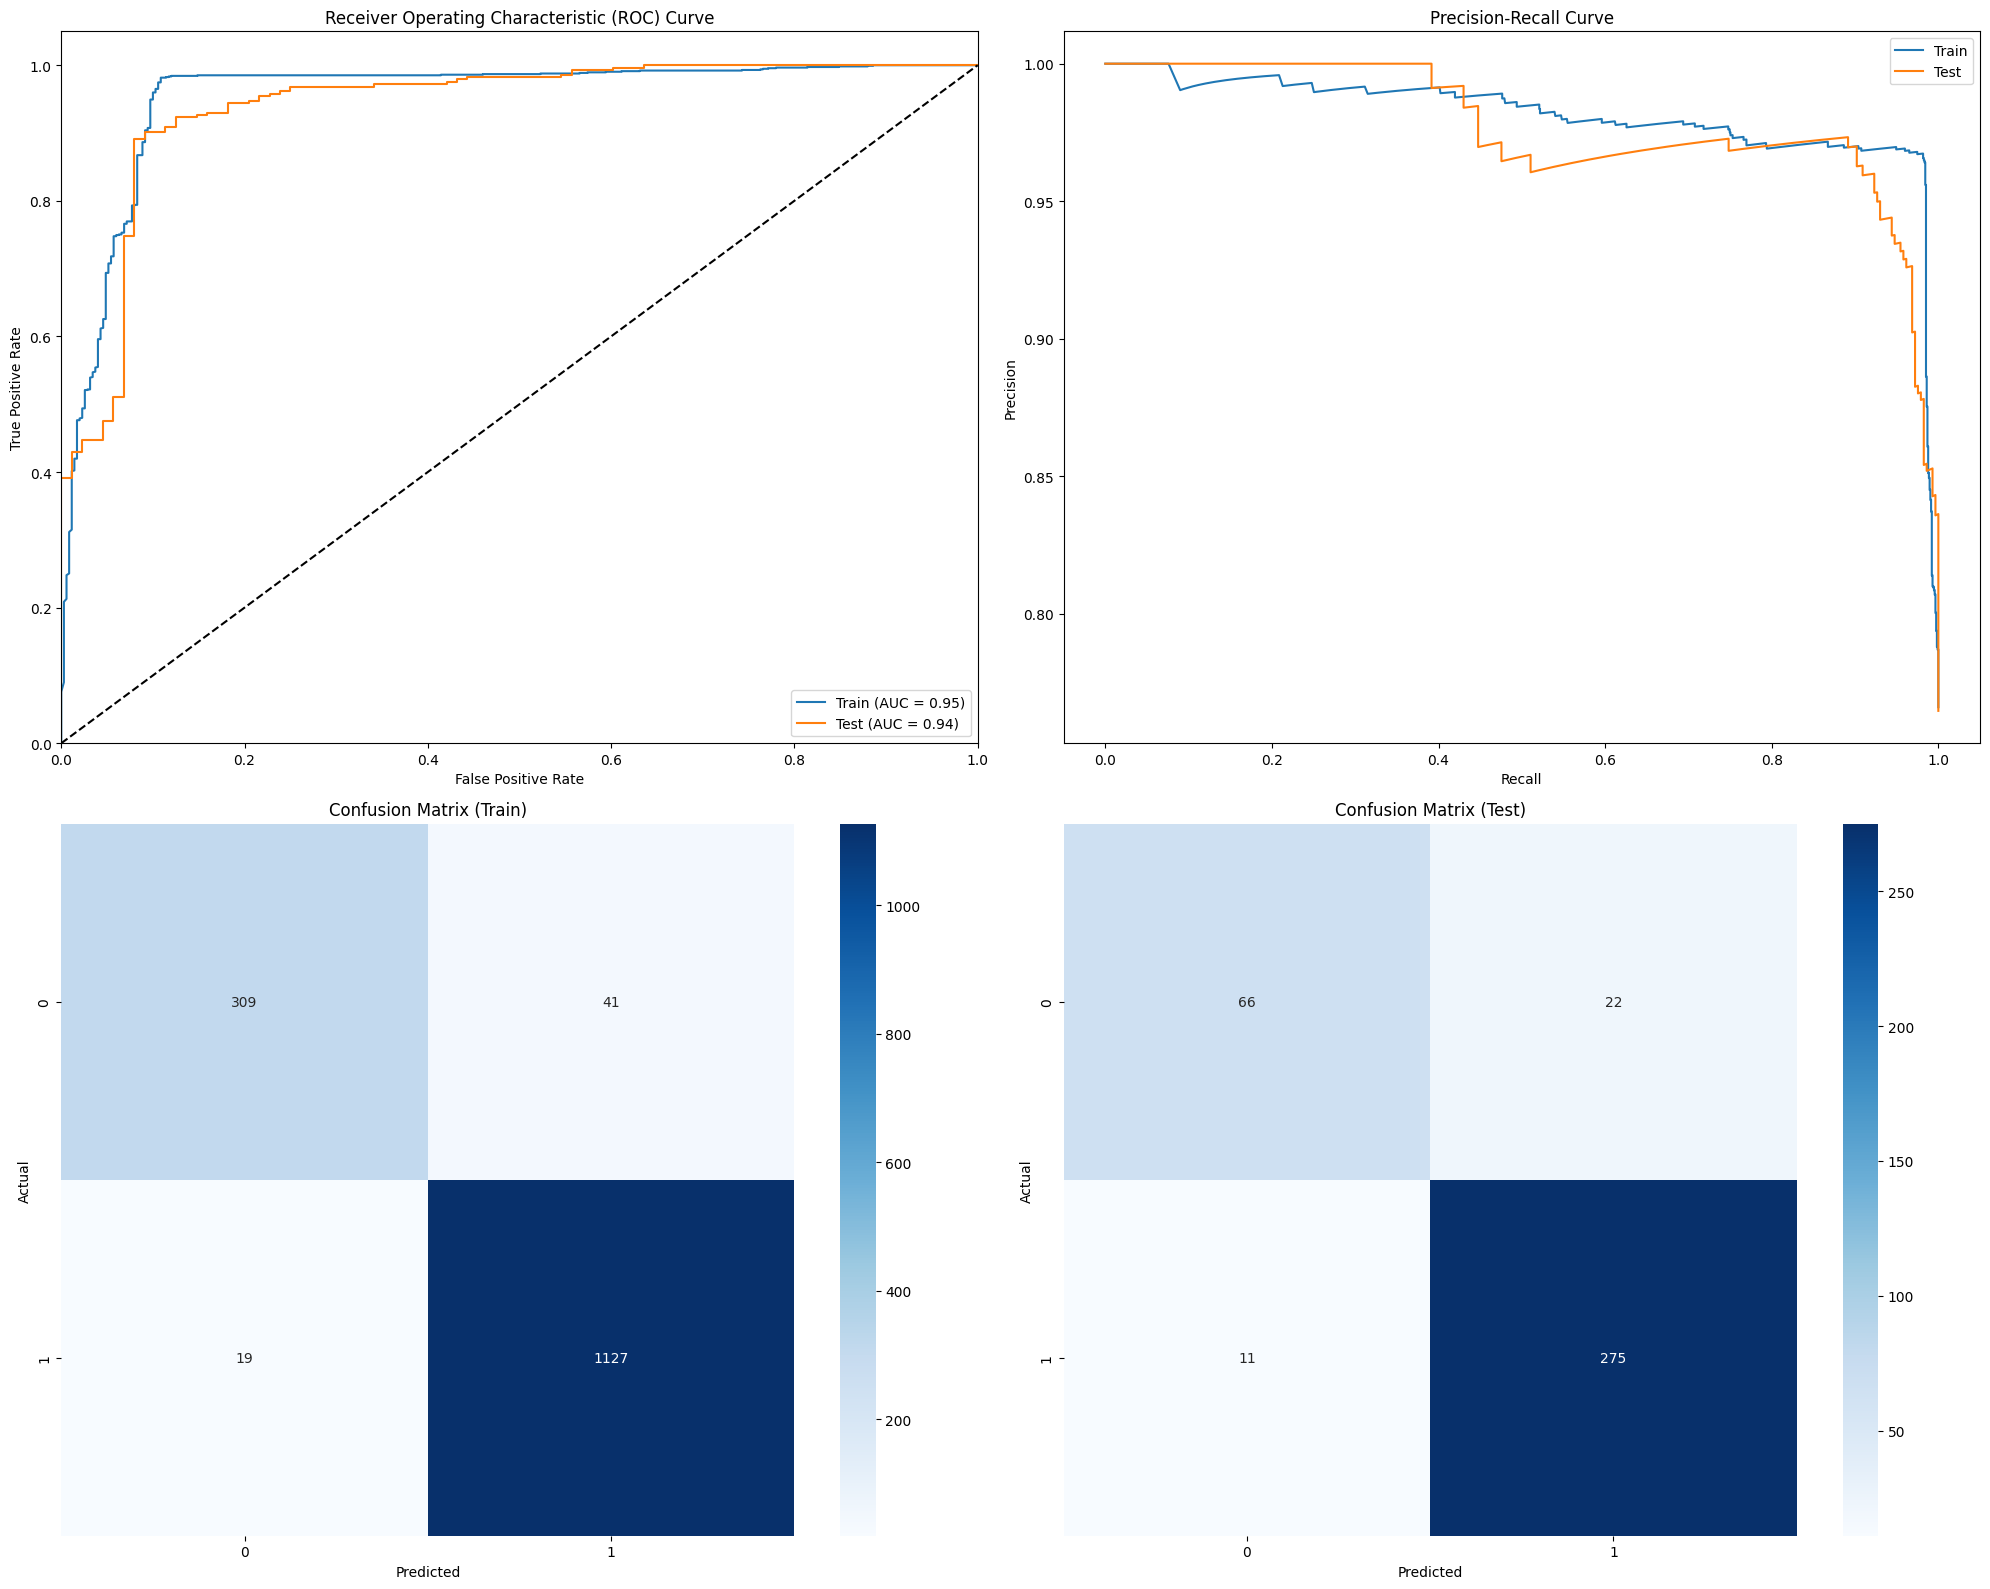

Model's state dictionary saved at GNN_optimal_state_dict.pth
Model disctionary object name:  GNN_optimal_state_dict.pth


In [2]:
!pip install torch_geometric
import pandas as pd
import re
import spacy
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import seaborn as sns
import torch.nn.functional as F
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')


def train(path):


    # Function for text preprocessing and lemmatization
    def preprocess_and_lemmatize(text):
        text = text.lower()
        text = re.sub(r'\?+', '?', text)
        text = re.sub(r'\!+', '!', text)
        text = re.sub(r'\/+', '', text)
        text = re.sub(r'`', '', text)
        text = re.sub(r'-lrb-', '-', text)
        text = re.sub(r'-rrb-', '-', text)
        text = re.sub(r'\-+', '-', text)
        text = re.sub(r"\b(i['`’]ve|i['`’]m|i['`’]ll)\b", lambda m: m.group(0).replace("'", " "), text)
        text = re.sub(r" - ", " . ", text)

        doc = nlp(text)
        lemmatized_tokens = [token.lemma_ for token in doc]
        lemmatized_text = ' '.join(lemmatized_tokens)
        lemmatized_text = re.sub(r"'s\b", "s", lemmatized_text)
        return lemmatized_text

    # Function to extract metaphor-related sentences
    def extract_metaphor_sentences(df):
        imp_text = []

        for _, row in df.iterrows():
            metaphor_keyword = metaphor_keywords.get(row['metaphorID'], '')
            selected_sentence = ""

            for sentence in row['lemmatized_text'].split('.'):
                if metaphor_keyword in sentence:
                    # Break condition: prioritize sentences without specific punctuation
                    if not any(punct in sentence for punct in [' - ', ' , ', ' ; ', ' ? ', ' ! ']):
                        selected_sentence = sentence
                        break

                    # Secondary prioritization based on punctuation
                    for punct in [' , ', ' ; ', ' ? ', ' ! ', ' - ']:
                        if punct in sentence:
                            for sub_sentence in sentence.split(punct):
                                if metaphor_keyword in sub_sentence:
                                    selected_sentence = sub_sentence
                                    break
                            if selected_sentence:
                                break

            if selected_sentence:
                imp_text.append(selected_sentence)

        return imp_text

    def clean_and_process_data(df):

        # Preprocess and lemmatize text
        df['lemmatized_text'] = df['text'].apply(preprocess_and_lemmatize)

        # Extract metaphor-related sentences
        imp_text = extract_metaphor_sentences(df)

        # Create cleaned DataFrame with important metaphor-related sentences
        cleaned_df = pd.DataFrame({'text': imp_text})
        cleaned_df[["metaphorID", "label"]] = df.iloc[:, :2]

        # Map labels to target binary values
        cleaned_df["target"] = cleaned_df["label"].map({True: 1, False: 0})
        cleaned_df = cleaned_df.drop("label", axis=1)

        # Map metaphorID to metaphor keywords
        cleaned_df["metaphor"] = cleaned_df["metaphorID"].map(metaphor_keywords)
        cleaned_df = cleaned_df.drop("metaphorID", axis=1)

        return cleaned_df

    metaphor_keywords = {
        0: 'road',
        1: 'candle',
        2: 'light',
        3: 'spice',
        4: 'ride',
        5: 'train',
        6: 'boat'
    }

    def create_bert_embeddings(text_series):
        embeddings = []
        for text in text_series:
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = bert_model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
        return torch.tensor(np.array(embeddings), dtype=torch.float)

    # Create a heterogeneous graph
    def create_hetero_graph(texts, metas):

        G = nx.Graph()

        word_to_doc_edges = []
        unique_words = set()

        for doc_id, (text, meta) in enumerate(zip(texts, metas)):
            words = set(str(text).lower().split() + str(meta).lower().split())
            unique_words.update(words)
            for word in words:
                word_to_doc_edges.append(('word', word, 'doc', doc_id))

        return list(unique_words), word_to_doc_edges


    def visualize_document_word_graph(data, num_docs=5, max_words_per_doc=20):
        """
        Visualizes a graph showing documents, words, and their connections.

        Args:
            data: The HeteroData object containing the graph.
            num_docs: Number of documents to visualize.
            max_words_per_doc: Maximum number of words to show per document.
        """
        edge_index = data['word', 'to', 'doc'].edge_index

        G = nx.Graph()

        all_docs = list(set(edge_index[1].tolist()))
        selected_docs = random.sample(all_docs, min(num_docs, len(all_docs)))

        # Add document nodes
        for doc_idx in selected_docs:
            G.add_node(f'doc_{doc_idx}', color='orange', node_type='doc')

        # Add word nodes and edges
        for doc_idx in selected_docs:
            connected_words = edge_index[0, edge_index[1] == doc_idx].tolist()
            selected_words = random.sample(connected_words, min(max_words_per_doc, len(connected_words)))
            for word_idx in selected_words:
                word_node = f'word_{word_idx}'
                if word_node not in G:
                    G.add_node(word_node, color='blue', node_type='word')
                G.add_edge(f'doc_{doc_idx}', word_node)

        # Visualization
        plt.figure(figsize=(20, 16))
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Draw nodes
        doc_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'doc']
        word_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'word']

        nx.draw_networkx_nodes(G, pos, nodelist=doc_nodes, node_color='orange', node_size=3000, alpha=0.8)
        nx.draw_networkx_nodes(G, pos, nodelist=word_nodes, node_color='blue', node_size=2000, alpha=0.6)

        # Draw edges
        nx.draw_networkx_edges(G, pos, alpha=0.5)

        # Add labels
        doc_labels = {node: node for node in doc_nodes}
        word_labels = {node: node.split('_')[1] for node in word_nodes}  # Display only the word index
        nx.draw_networkx_labels(G, pos, doc_labels, font_size=12, font_weight="bold")
        nx.draw_networkx_labels(G, pos, word_labels, font_size=8)

        plt.title("Document-Word Graph Visualization", fontsize=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


    def cross_validate(model_class, data, k_folds=2, **model_params):
        lr = model_params.pop('lr')  # Remove 'lr' from model_params
        kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        num_docs = data['doc'].x.size(0)
        doc_indices = np.arange(num_docs)
        fold_results = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(doc_indices)):
            print(f"Fold {fold+1}/{k_folds}")
            train_data = data.subgraph({'doc': train_idx})
            val_data = data.subgraph({'doc': val_idx})

            model = model_class(**model_params)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = torch.nn.CrossEntropyLoss()

            for epoch in range(200):
                loss = train(model, train_data, optimizer, criterion)
                if epoch % 10 == 0:
                    train_acc, _, _ = evaluate(model, train_data)
                    val_acc, _, _ = evaluate(model, val_data)
                    print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

            val_acc, _, _ = evaluate(model, val_data)
            fold_results.append(val_acc)

        return np.mean(fold_results), np.std(fold_results)

    def grid_search(data):
        param_grid = {
            'hidden_channels': [32, 64, 128],
            'num_layers': [2, 3, 4],
            'heads': [4, 8],
            'lr': [0.0001, 0.001, 0.01, 0.00001, 0.0000001]
        }

        best_score = 0
        best_params = {}

        for hidden_channels in param_grid['hidden_channels']:
            for num_layers in param_grid['num_layers']:
                for heads in param_grid['heads']:
                    for lr in param_grid['lr']:
                        print(f"Testing: hidden_channels={hidden_channels}, num_layers={num_layers}, heads={heads}, lr={lr}")
                        mean_score, std_score = cross_validate(
                            HeteroGNN,
                            data,
                            hidden_channels=hidden_channels,
                            out_channels=len(set(data['doc'].y.numpy())),
                            num_layers=num_layers,
                            heads=heads,
                            lr=lr
                        )

                        print(f"Mean validation f1 macro : {mean_score:.4f} (+/- {std_score:.4f})")
                        if mean_score > best_score:
                            best_score = mean_score
                            best_params = {
                                'hidden_channels': hidden_channels,
                                'num_layers': num_layers,
                                'heads': heads,
                                'lr': lr
                            }

        return best_params, best_score


    df = pd.read_csv(f'{path}')
    nlp = spacy.load('en_core_web_sm')
    df['label_boolean'] = df['label'].astype(int)
    cleaned_df = clean_and_process_data(df)

    X, y = cleaned_df.drop("target", axis = 1), cleaned_df["target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    X_train_text, X_test_text = X_train["text"],  X_test["text"]
    X_train_meta, X_test_meta = X_train["metaphor"], X_test["metaphor"]

    # Initialize BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')

    train_words, train_edges = create_hetero_graph(X_train_text, X_train_meta)
    test_words, test_edges = create_hetero_graph(X_test_text, X_test_meta)

    # Create features
    train_word_features = create_bert_embeddings(train_words)
    train_doc_features = create_bert_embeddings([text + " " + meta for text, meta in zip(X_train_text, X_train_meta)])

    test_word_features = create_bert_embeddings(test_words)
    test_doc_features = create_bert_embeddings([text + " " + meta for text, meta in zip(X_test_text, X_test_meta)])

    train_data = HeteroData()
    train_data['word'].x = train_word_features
    train_data['doc'].x = train_doc_features
    train_data['word', 'to', 'doc'].edge_index = torch.tensor([[train_words.index(edge[1]) for edge in train_edges],
                                                              [edge[3] for edge in train_edges]], dtype=torch.long)
    train_data['doc'].y = torch.tensor(y_train)

    test_data = HeteroData()
    test_data['word'].x = test_word_features
    test_data['doc'].x = test_doc_features
    test_data['word', 'to', 'doc'].edge_index = torch.tensor([[test_words.index(edge[1]) for edge in test_edges],
                                                              [edge[3] for edge in test_edges]], dtype=torch.long)
    test_data['doc'].y = torch.tensor(y_test)

    # Bidirectional Edges: Add reverse edges
    train_data['doc', 'to', 'word'].edge_index = train_data['word', 'to', 'doc'].edge_index.flip([0])
    test_data['doc', 'to', 'word'].edge_index = test_data['word', 'to', 'doc'].edge_index.flip([0])

    class HeteroGNN(torch.nn.Module):
        def __init__(self, hidden_channels, out_channels, num_layers, heads=4):
            super().__init__()
            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('word', 'to', 'doc'): GATConv((-1, -1), hidden_channels // heads, heads=heads, concat=True, add_self_loops=False),
                    ('doc', 'to', 'word'): GATConv((-1, -1), hidden_channels // heads, heads=heads, concat=True, add_self_loops=False),
                })
                self.convs.append(conv)
            self.lin = torch.nn.Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
                x_dict = {key: x.relu() for key, x in x_dict.items()}
            logits = self.lin(x_dict['doc'])
            return F.softmax(logits, dim=1)

    # Training and evaluation functions
    def train(model, data, optimizer, criterion):
        model.train()
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)
        loss = criterion(out, data['doc'].y)
        loss.backward()
        optimizer.step()
        return loss.item()

    def evaluate(model, data):
        model.eval()
        with torch.no_grad():
            out = model(data.x_dict, data.edge_index_dict)
            pred = out.argmax(dim=1).cpu().numpy()  # Convert predictions to numpy
            probs = out.cpu().numpy()  # Probabilities for further analysis
            true = data['doc'].y.cpu().numpy()  # Ground truth labels

            # Calculate F1-macro score
            f1_macro = f1_score(true, pred, average="macro")

            return f1_macro, pred, probs


    def compute_metrics(train_true, train_pred, train_probs, test_true, test_pred, test_probs):
        def calculate_metrics(y_true, y_pred, y_probs):
            metrics = {
                "Precision": precision_score(y_true, y_pred, average="macro"),
                "Recall": recall_score(y_true, y_pred, average="macro"),
                "F1-Score": f1_score(y_true, y_pred, average="macro"),
                "Accuracy": accuracy_score(y_true, y_pred),
                "ROC-AUC": roc_auc_score(y_true, y_probs[:, 1]) if y_probs is not None else None
            }
            return metrics

        train_metrics = calculate_metrics(train_true, train_pred, train_probs)
        test_metrics = calculate_metrics(test_true, test_pred, test_probs)

        df = pd.DataFrame({
            'Train': train_metrics,
            'Test': test_metrics
        }).transpose()

        display(df)

        print("\nClassification Report (Train):")
        print(classification_report(train_true, train_pred))

        print("\nClassification Report (Test):")
        print(classification_report(test_true, test_pred))

        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

        # ROC-AUC plot
        for true, probs, name in [(train_true, train_probs, 'Train'), (test_true, test_probs, 'Test')]:
            fpr, tpr, _ = roc_curve(true, probs[:, 1])
            roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
        ax1.legend(loc="lower right")

        # Precision-Recall plot
        for true, probs, name in [(train_true, train_probs, 'Train'), (test_true, test_probs, 'Test')]:
            precision, recall, _ = precision_recall_curve(true, probs[:, 1])
            ax2.plot(recall, precision, label=f'{name}')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curve')
        ax2.legend()

        # Confusion Matrix for Train data
        train_cm = confusion_matrix(train_true, train_pred)
        sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
        ax3.set_xlabel('Predicted')
        ax3.set_ylabel('Actual')
        ax3.set_title('Confusion Matrix (Train)')

        # Confusion Matrix for Test data
        test_cm = confusion_matrix(test_true, test_pred)
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
        ax4.set_xlabel('Predicted')
        ax4.set_ylabel('Actual')
        ax4.set_title('Confusion Matrix (Test)')

        plt.tight_layout()
        plt.show()

        return df


    # best_params, best_score = grid_search(train_data)
    #print(f"Best parameters: {best_params}")
    #print(f"Best cross-validation score: {best_score:.4f}")

    best_params =  {'hidden_channels': 32, 'num_layers': 2, 'heads': 8, 'lr': 0.001}
    GNN_optimal = HeteroGNN(
        hidden_channels=best_params['hidden_channels'],
        out_channels=len(set(y_train)),
        num_layers=best_params['num_layers'],
        heads=best_params['heads']
    )

    optimizer = torch.optim.Adam(GNN_optimal.parameters(), lr=best_params['lr'])
    criterion = torch.nn.CrossEntropyLoss()


    # Training loop
    train_losses, train_accuracies, val_accuracies = [], [], []

    epochs = 200

    for epoch in range(epochs):
        loss = train(GNN_optimal, train_data, optimizer, criterion)
        train_losses.append(loss)

        if epoch % 10 == 0:
            train_acc, _, _ = evaluate(GNN_optimal, train_data)
            val_acc, _, _ = evaluate(GNN_optimal, test_data)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    # Plot training loss
    ax1.plot(train_losses)
    ax1.set_title('Training Loss vs Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    # Plot accuracies
    ax2.plot(range(0, epochs, 10), train_accuracies, label='Train Accuracy')
    ax2.plot(range(0, epochs, 10), val_accuracies, label='Validation Accuracy')
    ax2.set_title('Accuracy vs Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


    # Final evaluation
    train_acc, train_pred, train_probs = evaluate(GNN_optimal, train_data)
    test_acc, test_pred, test_probs = evaluate(GNN_optimal, test_data)

    # Compute and display metrics
    metrics_df = compute_metrics(
        train_data['doc'].y.cpu().numpy(),
        train_pred,
        train_probs,
        test_data['doc'].y.cpu().numpy(),
        test_pred,
        test_probs
    )


    save_path = "GNN_optimal_state_dict.pth"

    # Save the model's state dictionary
    torch.save(GNN_optimal.state_dict(), save_path)

    print(f"Model's state dictionary saved at {save_path}")

    return save_path

path = 'train-1.csv'
model_state_dict_path = train(path)
print("Model disctionary object name: ", model_state_dict_path)



In [ ]:
# Add remaining code here
'''


'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>